# Libraries

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing Helper Functions
from helper_functions import drop_extraneous_col
# Recursive Feature Elimination with Cross-Validation
from sklearn.feature_selection import RFECV
# Time Series Split and GridSearchCV, where GridSearchCV is for hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate, RandomizedSearchCV
# Pipeline
from sklearn.pipeline import Pipeline
# Standard Scalar
from sklearn.preprocessing import StandardScaler
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve, RocCurveDisplay
# Logistic Regression, Ridge Classifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# XGBoost
from xgboost import XGBClassifier
# Support Vector Machine (SVM)
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

# Using the Cumulative Averages DataFrame

In [4]:
training_df  = pd.read_csv('/Users/josephlim/Documents/3B/MSCI 446/MSCI-446-Project/csvs/cumulative_averages.csv')
drop_extraneous_col(training_df)
training_df

,team0,team1,winner,season,date,team0_encoded,team1_encoded,restDays_team0,restDays_team1,mp_cumulative_team0,...,blk%_cumulative_team1,tov%_cumulative_team0,tov%_cumulative_team1,ortg_cumulative_team0,ortg_cumulative_team1,drtg_cumulative_team0,drtg_cumulative_team1,ft/fga_cumulative_team0,ft/fga_cumulative_team1,team1_winner
0,CLE,MIL,CLE,2018,2017-10-20,6,10,2.0,1.0,240.000000,...,6.300000,15.300000,14.400000,102.700000,110.400000,99.700000,102.200000,0.253000,0.329000,0
1,LAL,PHO,LAL,2018,2017-10-20,25,24,0.0,1.0,240.000000,...,12.100000,15.800000,14.200000,86.900000,77.000000,102.000000,125.600000,0.154000,0.146000,0
2,GSW,NOP,GSW,2018,2017-10-20,21,30,2.0,1.0,240.000000,...,19.000000,16.000000,15.600000,118.600000,97.600000,119.600000,110.400000,0.238000,0.304000,0
3,ORL,BRK,BRK,2018,2017-10-20,15,4,1.0,1.0,240.000000,...,2.900000,12.000000,15.600000,110.300000,115.700000,103.600000,123.600000,0.244000,0.309000,1
4,BOS,PHI,BOS,2018,2017-10-20,2,5,1.0,1.0,240.000000,...,8.000000,9.950000,14.400000,100.950000,110.300000,106.550000,115.100000,0.168500,0.151000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8350,MIL,BOS,BOS,2024,2024-03-20,10,2,2.0,1.0,241.119403,...,11.938235,10.864179,10.339706,119.949254,124.129412,116.650746,112.086765,0.221627,0.189853,1
8351,PHI,PHO,PHO,2024,2024-03-20,5,24,1.0,2.0,240.735294,...,10.926471,10.083824,12.583824,117.983824,118.973529,115.505882,116.622059,0.229985,0.231632,1
8352,MIA,CLE,MIA,2024,2024-03-20,11,6,1.0,1.0,240.384615,...,8.794118,10.978462,11.560294,114.193846,116.600000,113.412308,112.476471,0.216354,0.183294,0
8353,LAC,POR,LAC,2024,2024-03-20,22,17,2.0,1.0,240.373134,...,8.408955,11.274627,12.708955,120.468657,110.244776,116.623881,118.516418,0.216194,0.192925,0


In [116]:
training_df['team1_winner'].sum()/training_df.shape[0]

0.5658886894075404

# Splitting Dataframe into Train and Test

In [5]:
undesired_columns = ['team0', 'team1', 'winner', 'season', 'date', 'team1_winner']
# We decided to train from the 2018 season to the 2023 season
training_seasons = [2018,2019,2020,2021,2022,2023]
# Splitting the dataframe into train and test
X_train = training_df[training_df['season'].isin(training_seasons)].drop(undesired_columns, axis=1)
X_test = training_df[training_df['season'] == 2024].drop(undesired_columns, axis=1)
y_train = training_df[training_df['season'].isin(training_seasons)]['team1_winner']
y_test = training_df[training_df['season'] == 2024]['team1_winner']


In [6]:
# Double checking the shapes of the training and testing dataframes

print(f'Observations in X_train: {X_train.shape[0]}')
print(f'Observations in y_train: {y_train.shape[0]}')

print(f'Observations in X_test: {X_test.shape[0]}')
print(f'Observations in y_test: {y_test.shape[0]}')


Observations in X_train: 7348
Observations in y_train: 7348
Observations in X_test: 1007
Observations in y_test: 1007


# Scaling Features

In [7]:
std_scalar = StandardScaler()
X_train = std_scalar.fit_transform(X_train)
X_test = std_scalar.fit_transform(X_test) 

# Defining the Type of Cross Validation

In [8]:
# Define the type of cross validation
tscv = TimeSeriesSplit()

# Creating a Results DataFrame to Store Training and Validation Scores

In [9]:
results_df = pd.DataFrame(columns=['Model', 'Training Accuracy', 'Validation Accuracy',
                             'Training Precision', 'Validation Precision',
                             'Training Recall ', 'Validation Recall',
                             'Training F1', 'Validation F1',
                             'Training ROC_AUC', 'Validation ROC_AUC'])

# Logistic Regression

In [10]:
# Define the Logistic Regresion Model
model_lr = LogisticRegression(solver='saga', max_iter=5000, random_state=42)
# Define the Recursive Feature Elimination Cross Validation
model_rfecv_lr = RFECV(estimator = model_lr, cv=tscv, min_features_to_select=30, scoring='accuracy')
# Fitting the rfecv model to the data
model_rfecv_lr.fit(X_train, y_train)
# Transforming the the training dataset to only have the selected features
X_train_selected = model_rfecv_lr.transform(X_train)
# Define a grid of hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=tscv, scoring=scoring, refit='accuracy', verbose=1, return_train_score=True)
grid_search_lr.fit(X_train_selected,y_train)

cv_results_lr = grid_search_lr.cv_results_

new_row_data = ['Logistic Regression']
for scorer in scoring:
    best_validation_score = cv_results_lr[f'mean_test_{scorer}'].max()
    i = list(cv_results_lr[f'mean_test_{scorer}']).index(best_validation_score)
    train_score = list(cv_results_lr[f'mean_train_{scorer}'])[i]
    new_row_data.extend([train_score,best_validation_score])

new_row_series = pd.Series(new_row_data, index=results_df.columns)
results_df = pd.concat([results_df, pd.DataFrame(new_row_series).T], axis=0, ignore_index=True)

num_features_lr = model_rfecv_lr.n_features_
best_params_lr = grid_search_lr.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


# Random Forest Classifier

In [11]:
# Define the RandomForestClassifier Model
model_rfc = RandomForestClassifier(random_state=42)
# Define the Recursive Feature Elimination Cross Validation
model_rfecv_rfc = RFECV(estimator = model_rfc, cv=tscv, min_features_to_select=30, scoring='accuracy')
# Fitting the rfecv model to the data
model_rfecv_rfc.fit(X_train, y_train)
# Transforming the the training dataset to only have the selected features
X_train_selected = model_rfecv_rfc.transform(X_train)
# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 500],       # Number of trees in the forest.
    'max_depth': [None, 10, 20, 30],        # Maximum depth of the tree.
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node.
    'min_samples_leaf': [1, 2, 4], 
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

random_search_rfc = RandomizedSearchCV(estimator=model_rfc, n_iter=100, param_distributions=param_grid, cv=tscv, scoring=scoring, refit='accuracy', verbose=1, return_train_score=True)
random_search_rfc.fit(X_train_selected,y_train)

cv_results_rfc = random_search_rfc.cv_results_

new_row_data = ['Random Forest Classifier']
for scorer in scoring:
    best_validation_score = cv_results_rfc[f'mean_test_{scorer}'].max()
    i = list(cv_results_rfc[f'mean_test_{scorer}']).index(best_validation_score)
    train_score = list(cv_results_rfc[f'mean_train_{scorer}'])[i]
    new_row_data.extend([train_score,best_validation_score])

new_row_series = pd.Series(new_row_data, index=results_df.columns)
results_df = pd.concat([results_df, pd.DataFrame(new_row_series).T], axis=0, ignore_index=True)

num_features_rfc = model_rfecv_rfc.n_features_
best_params_rfc = random_search_rfc.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


# XGBoost Classifier

In [12]:
# Define the XGB Classifier Model
model_xgb = XGBClassifier(objective='binary:logistic')
# Define the Recursive Feature Elimination Cross Validation
model_rfecv_xgb = RFECV(estimator = model_xgb, cv=tscv, min_features_to_select=30, scoring='accuracy')
# Fitting the rfecv model to the data
model_rfecv_xgb.fit(X_train, y_train)
# Transforming the the training dataset to only have the selected features
X_train_selected = model_rfecv_xgb.transform(X_train)
# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

random_search_xgb = RandomizedSearchCV(estimator=model_xgb, n_iter=100, param_distributions=param_grid, cv=tscv, scoring=scoring, refit='accuracy', verbose=1, return_train_score=True)
random_search_xgb.fit(X_train_selected,y_train)

cv_results_xgb = random_search_xgb.cv_results_

new_row_data = ['XGB Classifier']
for scorer in scoring:
    best_validation_score = cv_results_xgb[f'mean_test_{scorer}'].max()
    i = list(cv_results_xgb[f'mean_test_{scorer}']).index(best_validation_score)
    train_score = list(cv_results_xgb[f'mean_train_{scorer}'])[i]
    new_row_data.extend([train_score,best_validation_score])

new_row_series = pd.Series(new_row_data, index=results_df.columns)
results_df = pd.concat([results_df, pd.DataFrame(new_row_series).T], axis=0, ignore_index=True)

num_features_xgb = model_rfecv_xgb.n_features_
best_params_xgb = random_search_xgb.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


# Support Vector Machine

In [13]:
# Define the Support Vector Machine Model
model_svm = LinearSVC(max_iter=5000, random_state=42, dual='auto')
# Define the Recursive Feature Elimination Cross Validation
model_rfecv_svm = RFECV(estimator = model_svm, cv=tscv, min_features_to_select=30, scoring='accuracy')
# Fitting the rfecv model to the data
model_rfecv_svm.fit(X_train, y_train)
# Transforming the the training dataset to only have the selected features
X_train_selected = model_rfecv_svm.transform(X_train)
# Define a grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

grid_search_svm = GridSearchCV(estimator=model_svm, param_grid=param_grid, cv=tscv, scoring=scoring, refit='accuracy', verbose=1, return_train_score=True)
grid_search_svm.fit(X_train_selected,y_train)

cv_results_svm = grid_search_svm.cv_results_

new_row_data = ['Linear SVC']
for scorer in scoring:
    best_validation_score = cv_results_svm[f'mean_test_{scorer}'].max()
    i = list(cv_results_svm[f'mean_test_{scorer}']).index(best_validation_score)
    train_score = list(cv_results_svm[f'mean_train_{scorer}'])[i]
    new_row_data.extend([train_score,best_validation_score])

new_row_series = pd.Series(new_row_data, index=results_df.columns)
results_df = pd.concat([results_df, pd.DataFrame(new_row_series).T], axis=0, ignore_index=True)

num_features_svm = model_rfecv_svm.n_features_
best_params_svm = grid_search_svm.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [14]:
results_df

,Model,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1,Validation F1,Training ROC_AUC,Validation ROC_AUC
0,Logistic Regression,0.653162,0.636438,0.668556,0.662558,0.899976,0.89268,0.736639,0.720072,0.627854,0.621808
1,Random Forest Classifier,0.975172,0.625,0.946869,0.640771,0.994993,0.784625,0.978879,0.702098,0.956667,0.603428
2,XGB Classifier,0.739913,0.621895,0.963832,0.640903,0.918064,0.885083,0.784643,0.722111,0.718699,0.59878
3,Linear SVC,0.653512,0.632026,0.667506,0.653756,0.803963,0.755788,0.728051,0.697753,0.625755,0.614282


In [15]:
results_df.to_csv('cumulative_averages_results.csv')

In [118]:
# Number of features selected by each model
print(f'Logistic Regression: {num_features_lr}')
print(f'Random Forest Classifier: {num_features_rfc}')
print(f'XGB Classifier: {num_features_xgb}')
print(f'LinearSVC: {num_features_svm}')

Logistic Regression: 36
Random Forest Classifier: 33
XGB Classifier: 67
LinearSVC: 51


In [119]:
# Best parameters for each model
print(f'Logistic Regression: {best_params_lr}')
print(f'Random Forest Classifier: {best_params_rfc}')
print(f'XGB Classifier: {best_params_xgb}')
print(f'LinearSVC: {best_params_svm}')

Logistic Regression: {'C': 1, 'penalty': 'l2'}
Random Forest Classifier: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30}
XGB Classifier: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.5}
LinearSVC: {'C': 0.1, 'penalty': 'l2'}


# Choosing the Best Performing Model

In [86]:
# Through comparison, it was found that the features in the cumulative_averages dataframe
# performed the best for the following models: Logistic Regression, XGBoost Classifier, LinearSVC, as it gave the highest validation accuracy.

# We will test these models under the cumulative_averages dataframe

# Transform the X_test dataframe using the same transformation applied to the X_train dataframe
X_test_transformed_lr = model_rfecv_lr.transform(X_test)
X_test_transformed_xgb = model_rfecv_xgb.transform(X_test)
X_test_transformed_svm = model_rfecv_svm.transform(X_test)
# Use the best model
best_model_lr = grid_search_lr.best_estimator_
best_model_xgb = random_search_xgb.best_estimator_
best_model_svm = grid_search_svm.best_estimator_

# Testing the Model

In [87]:
# Make predictions using the best model
preds_lr = best_model_lr.predict(X_test_transformed_lr)
preds_xgb = best_model_xgb.predict(X_test_transformed_xgb)
preds_svm = best_model_svm.predict(X_test_transformed_svm)

# Model Performance Evaulation

Logistic Regression

In [88]:
# Compute Performance Metrics for Logistic Regression
print(classification_report(y_test, preds_lr))

              precision    recall  f1-score   support

           0       0.63      0.45      0.53       454
           1       0.64      0.79      0.70       553

    accuracy                           0.63      1007
   macro avg       0.63      0.62      0.61      1007
weighted avg       0.63      0.63      0.62      1007



In [89]:
print(f'The accuracy of the Logistic Regression Model is: {accuracy_score(y_test, preds_lr)}')

The accuracy of the Logistic Regression Model is: 0.634558093346574


Text(0.5, 1.0, 'Confusion Matrix for the Logistic Regression Model')

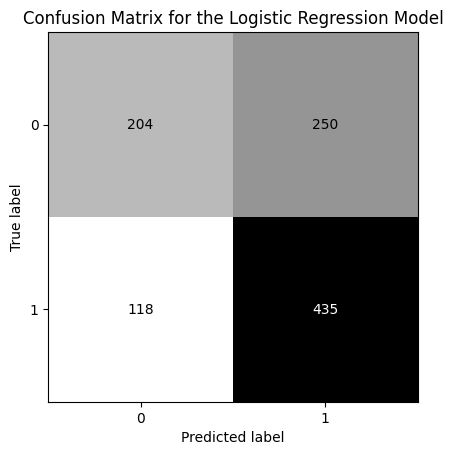

In [111]:
cm_lr = confusion_matrix(y_test, preds_lr)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm_lr)
cm_display_lr.plot(cmap='binary', colorbar=False)
plt.title('Confusion Matrix for the Logistic Regression Model')

XGB Classifier

In [91]:
# Compute Performance Metrics for XGB Classifier
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.65      0.38      0.48       454
           1       0.62      0.83      0.71       553

    accuracy                           0.63      1007
   macro avg       0.64      0.61      0.60      1007
weighted avg       0.64      0.63      0.61      1007



In [92]:
print(f'The accuracy of the XGB Classifier is: {accuracy_score(y_test, preds_xgb)}')

The accuracy of the XGB Classifier is: 0.6305858987090367


Text(0.5, 1.0, 'Confusion Matrix for the XGB Classifier Model')

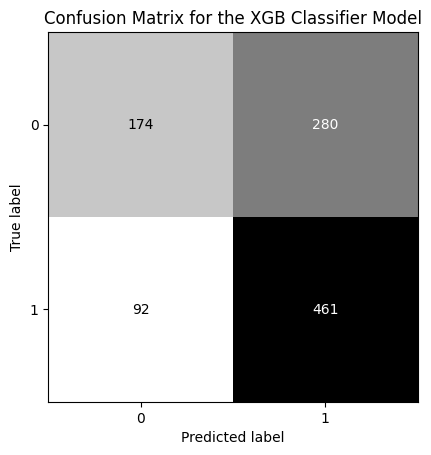

In [110]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix = cm_xgb)
cm_display_xgb.plot(cmap='binary', colorbar=False)
plt.title('Confusion Matrix for the XGB Classifier Model')

Support Vector Machine

In [94]:
# Compute Performance Metrics for Support Vector Machine
print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           0       0.65      0.44      0.53       454
           1       0.64      0.80      0.71       553

    accuracy                           0.64      1007
   macro avg       0.64      0.62      0.62      1007
weighted avg       0.64      0.64      0.63      1007



In [95]:
print(f'The accuracy of the LinearSVC model is: {accuracy_score(y_test, preds_svm)}')

The accuracy of the LinearSVC model is: 0.6395233366434955


Text(0.5, 1.0, 'Confusion Matrix for the LinearSVC Model')

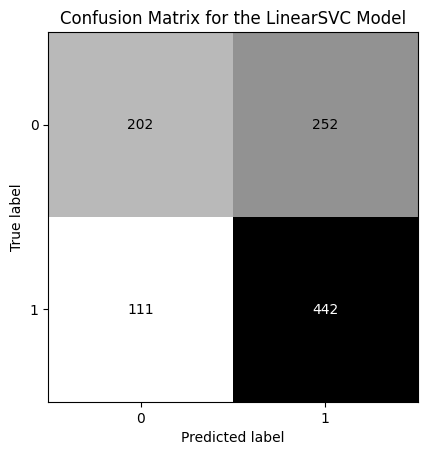

In [112]:
cm_svm = confusion_matrix(y_test, preds_svm)
cm_display_svm  = ConfusionMatrixDisplay(confusion_matrix = cm_svm)
cm_display_svm.plot(cmap='binary', colorbar=False)
plt.title('Confusion Matrix for the LinearSVC Model')

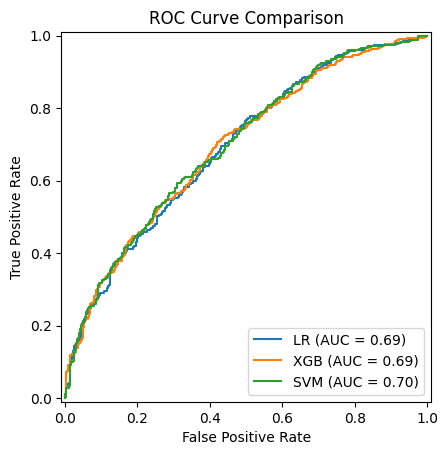

In [97]:
# Create a figure and axis object
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(best_model_lr, X_test_transformed_lr, y_test, ax=ax, name='LR')
RocCurveDisplay.from_estimator(best_model_xgb, X_test_transformed_xgb, y_test, ax=ax, name='XGB')
RocCurveDisplay.from_estimator(best_model_svm, X_test_transformed_svm, y_test, ax=ax, name='SVM')

# Optional: Customize the plot with title, labels, etc.
ax.set_title('ROC Curve Comparison')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Display the plot
plt.show()